In [2]:
import pandas as pd
from scipy.io import arff
import matplotlib.pyplot as plt
import pickle

# Progress bar
from tqdm import tqdm

# Models
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import lightgbm as ltb

# Custom classes
import sys
sys.path.insert(0,'..')
from meta_learning import MetaLearner, Model, evaluator, MetaModel
from utils import load_dataset

# Ignoring warnings
import warnings
warnings.filterwarnings('ignore')

## Macros

In [13]:
META_LABEL_METRIC = "kappa"
DATASET = "covtype"
INCLUDE_DRIFT_METRICS = True

BASE_MODEL = RandomForestClassifier
# BASE_MODEL_HYPERPARAMS = {"probability": True}  # SVC
BASE_MODEL_HYPERPARAMS = {"max_depth": 6}  # RandomForest and DecisionTree
# BASE_MODEL_HYPERPARAMS = {}  # Logistic Regression

FILE_NAME = f"basemodel: {BASE_MODEL.__name__} - metric: {META_LABEL_METRIC} - dataset: {DATASET}"
if INCLUDE_DRIFT_METRICS:
    FILE_NAME += " - with_drift_metrics"
FILE_NAME

'basemodel: RandomForestClassifier - metric: kappa - dataset: covtype - with_drift_metrics'

In [14]:
# Macros
CLASS_COL = "class"
BASE_MODEL_TYPE = "binary_classification"  # multiclass or binary_classification or regression

OFFLINE_PHASE_SIZE = 5000
BASE_TRAIN_SIZE = 2000
R_STATE = 123

ETA = 100  # Window size used to extract meta features (100 for electricity)
STEP = 30  # Step for next meta learning iteration (30 for electricity)
TARGET_DELAY = 500

## Read data

In [15]:
df = load_dataset(DATASET)
print(df.shape)
df.head()

(581012, 55)


,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,class
0,0.368684,0.141667,0.045455,0.184681,0.223514,0.071659,0.870079,0.913386,0.582677,0.875366,...,0,0,0,0,0,0,0,0,0,4
1,0.365683,0.155556,0.030303,0.151754,0.215762,0.054798,0.866142,0.925197,0.594488,0.867838,...,0,0,0,0,0,0,0,0,0,4
2,0.472736,0.386111,0.136364,0.191840,0.307494,0.446817,0.921260,0.937008,0.531496,0.853339,...,0,0,0,0,0,0,0,0,0,1
3,0.463232,0.430556,0.272727,0.173228,0.375969,0.434172,0.937008,0.937008,0.480315,0.865886,...,0,0,0,0,0,0,0,0,0,1
4,0.368184,0.125000,0.030303,0.109520,0.222222,0.054939,0.866142,0.921260,0.590551,0.860449,...,0,0,0,0,0,0,0,0,0,4


In [16]:
n = df.shape[0]
class_weight = df[CLASS_COL].value_counts().apply(lambda x: x/n).to_dict()
class_weight

{1: 0.48759922342395684,
 0: 0.36460520608868663,
 2: 0.06153745533655071,
 6: 0.03530047572167184,
 5: 0.02989094889606411,
 4: 0.016338733107061472,
 3: 0.004727957426008413}

In [6]:
# offline
offline_df = df.iloc[:OFFLINE_PHASE_SIZE]
base_train_df = offline_df.iloc[:BASE_TRAIN_SIZE]
meta_train_df = offline_df.iloc[BASE_TRAIN_SIZE:]

# online
online_df = df.iloc[OFFLINE_PHASE_SIZE:]
online_features = online_df.drop(CLASS_COL, axis=1).reset_index(drop=True)
online_targets = online_df[CLASS_COL].reset_index(drop=True)

## Offline stage

In [7]:
base_model = Model(verbose=True, basis_model=BASE_MODEL, hyperparameters=BASE_MODEL_HYPERPARAMS)
meta_model = MetaModel()
learner_params = {
    "base_model": base_model,
    "meta_model": meta_model,
    "base_model_class_column": CLASS_COL,
    "eta": ETA,
    "step": STEP,
    "meta_label_metric": META_LABEL_METRIC,
    "verbose": True,
    "target_delay": TARGET_DELAY,
    "base_model_type": BASE_MODEL_TYPE,
    "include_drift_metrics_mfs": INCLUDE_DRIFT_METRICS,
    }

learner = MetaLearner(**learner_params).fit(base_train_df, meta_train_df)

## Online Stage

In [ ]:
# start - no target
with tqdm(total=TARGET_DELAY) as pbar:
    for i, row in online_features.iloc[:TARGET_DELAY].iterrows():
        learner.update(row)
        pbar.update(1)

100%|██████████| 500/500 [00:27<00:00, 18.38it/s]


In [ ]:
# middle - both target and instances
df = online_features.iloc[TARGET_DELAY:-TARGET_DELAY]

with tqdm(total=df.shape[0]) as pbar:
    for i, row in df.iterrows():
        learner.update(row)
        learner.update_target(online_targets.iloc[i - TARGET_DELAY])
        pbar.update(1)

  1%|          | 486/39312 [00:41<51:07, 12.66it/s]  

In [ ]:
# end - only targets
with tqdm(total=TARGET_DELAY) as pbar:
    for target in online_targets.tail(TARGET_DELAY):
        learner.update_target(target)
        pbar.update(1)

 90%|█████████ | 451/500 [00:00<00:00, 1267.30it/s]

Training model with instances 1320 to 1417


100%|██████████| 500/500 [00:00<00:00, 1255.44it/s]


## Results

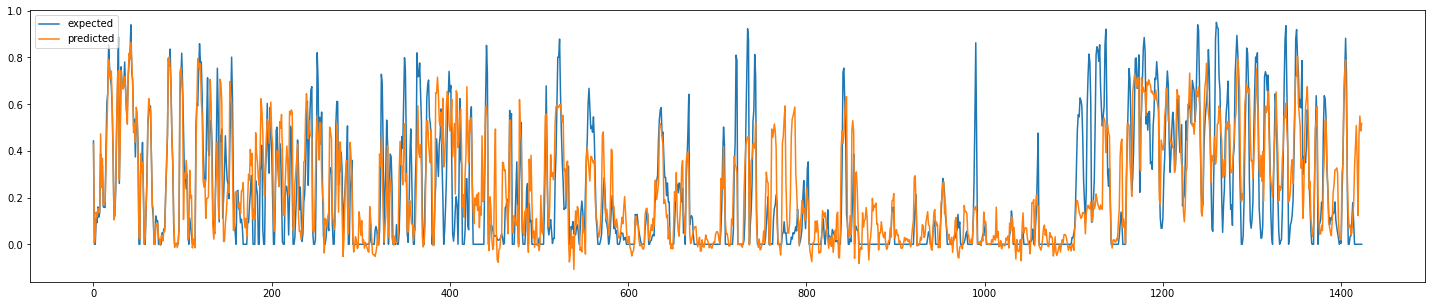

In [ ]:
mb = learner.metabase.metabase

y_true = mb[META_LABEL_METRIC]
y_pred = mb['predicted']
x = range(len(y_true))

fig = plt.figure(figsize=(25, 5))
plt.plot(x, y_true, label="expected")
plt.plot(x, y_pred, label="predicted")
plt.legend(loc="upper left")

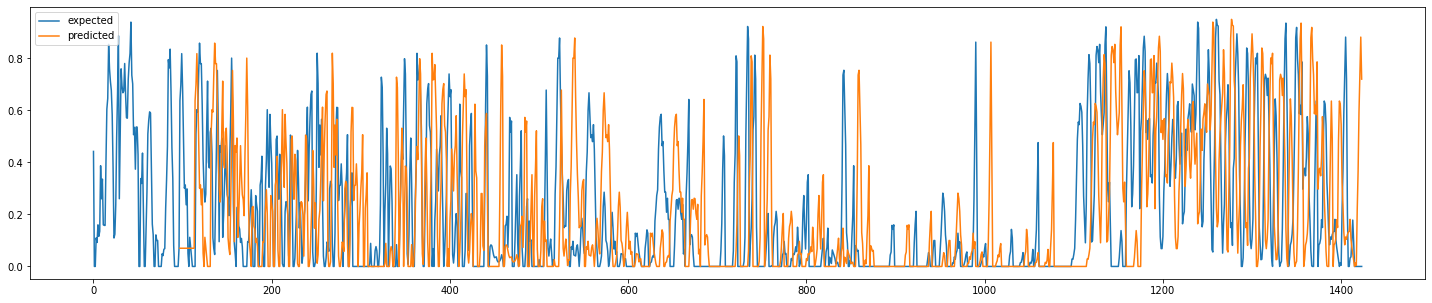

In [ ]:
mb = learner.metabase.metabase

y_true = mb[META_LABEL_METRIC]
y_pred = mb[f'last_{META_LABEL_METRIC}']
x = range(len(y_true))

fig = plt.figure(figsize=(25, 5))
plt.plot(x, y_true, label="expected")
plt.plot(x, y_pred, label="predicted")
plt.legend(loc="upper left")

# Save metadata

In [ ]:
mb.to_csv(f"metabases/{FILE_NAME}.csv", index=False)

In [ ]:
with open(f"models/{FILE_NAME}.pickle", "wb") as handle:
    pickle.dump(learner.meta_model.model, handle, protocol=pickle.HIGHEST_PROTOCOL)